# Practical 6. Modelling differentiation between pairs of populations


At the end of this practical you should:

- Know how to estimate differentiation between populations/species using $d_{xy}$, $d_{net}$ and $F_{st}$ and understand how these summary statistics are defined and related to each other.
- Be able to use coalescent theory to relate estimates of divergence and differentiation obtained from whole genome data to models of equilibrium population structure and non-equilibrium population history.
- Be able to define outliers of differentiation in a genome scan.
- Be able to simulate sequence data under models of population structure and compare these to real data.

## 6.1. Import data

In [21]:
import msprime
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
%matplotlib inline
#The default figure size is too small, this increases the default:
plt.rcParams['figure.figsize'] = [15, 7]
import numpy as np
import allel
import warnings
warnings.filterwarnings('ignore')

We will import a variant only vcf file containing variation data several individuals of *Heliconius* butterflies belonging to different closely related species and mimicry races.

To keep things manageable, we will focus on a single chromosome (18) in the practical.


These data were obtained by mapping WGS Illumina reads against the *Heliconius melpomene* reference genome are from [(Martin et al 2020)](https://datadryad.org/stash/dataset/doi:10.5061/dryad.sk2pd88). The feature as an example dataset in a seminal review of speciation genomics which discusses the limitations of genome scans [(Seehausen 2014, Fig 1)](https://www.nature.com/articles/nrg3644).

As in the last two practicals, we will use the `allel` function `read_vcf`. Because the vfc has been filtered we only need to read in GTs, positions and samples. 

In [22]:
query_fields = ['samples', 'calldata/GT', 'variants/CHROM', 'variants/POS', 'variants/is_snp']

In [23]:
# Need to update the import on we have the data on git...
vcf_f ='/home/konrad/Dropbox/Konrad_Teaching/Population_Genomic_Analysis/Martin_et_al_2020/heli_chrom18.vcf.gz'
helidata = allel.read_vcf(vcf_f, fields = query_fields)

It is convenient to store the genotype data as an array (see practical 4). Let's save this as `heliGTs`.

In [24]:
heliGTs = allel.GenotypeArray(helidata['calldata/GT']);
heliGTs

<GenotypeArray shape=(1441823, 52, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/1 ... 0/1 0/0 ./. 0/0 0/0
...
0/0 ./. 0/0 0/0 0/0 ... ./. 0/0 0/0 0/0 0/0
0/0 ./. 0/0 0/0 0/0 ... ./. 0/0 0/1 0/0 0/0
0/0 ./. 0/0 0/0 0/0 ... ./. 0/1 0/1 0/0 0/0

<div class="alert alert-block alert-success">    
    <b>Exercise 1:</b> Check the ploidy, the number of samples and the number of variants and whether the data are phased. Are all variants SNPs?
    </div>

In [25]:
#SOL
pos = helidata['variants/POS'];
chrom18Len = pos[-1];
samples = helidata['samples'];
print("The ploidy is:", heliGTs.ploidy)
print("Number of samples in vcf is: ", heliGTs.n_samples)
print("Number of variants in vcf is: ", heliGTs.n_variants)
print(heliGTs.is_phased)

The ploidy is: 2
Number of samples in vcf is:  52
Number of variants in vcf is:  1441823
None


In [26]:
is_SNP_df = pd.DataFrame({'is_snp': helidata['variants/is_snp']})
print(is_SNP_df.value_counts())

is_snp
True      1441823
dtype: int64


The dataset includes 10 samples from each of the following 5 taxa:

        malleti 
        rosina
        amaryllis
        flo
        cydno

<div class="alert alert-block alert-success">    
    <b>Exercise 2:</b> Print the names of the samples included in this file.  Which samples belong to which taxon?
    </div>

The list of samples is:

In [27]:
#SOL
print(samples)

['ros.CAM1841' 'ros.CAM1880' 'ros.CAM2045' 'ros.CAM2059' 'ros.CAM2519'
 'ros.CAM2552' 'ros.CJ2071' 'ros.CJ531' 'ros.CJ533' 'ros.CJ546'
 'mal.CS1002' 'mal.CS1011' 'mal.CS1815' 'mal.CS21' 'mal.CS22' 'mal.CS24'
 'mal.CS586' 'mal.CS594' 'mal.CS604' 'mal.CS615' 'ama.JM160' 'ama.JM216'
 'ama.JM293' 'ama.JM48' 'ama.MJ11-3188' 'ama.MJ11-3189' 'ama.MJ11-3202'
 'ama.MJ12-3217' 'ama.MJ12-3258' 'ama.MJ12-3301' 'chi.CAM25091'
 'chi.CAM25137' 'chi.CAM580' 'chi.CAM582' 'chi.CAM585' 'chi.CAM586'
 'chi.CJ553' 'chi.CJ560' 'chi.CJ564' 'chi.CJ565' 'flo.CS12' 'flo.CS13'
 'flo.CS14' 'flo.CS15' 'flo.CS2337' 'flo.CS2338' 'flo.CS2341' 'flo.CS2350'
 'flo.CS2358' 'flo.CS2359' 'nu_sil.MJ09-4125' 'nu_sil.MJ09-4184']


<div class="alert alert-block alert-success">    
    <b>Exercise 3:</b>  What is the position of the first and last variant on chromosome 18? Define the position of the last variant as the length of the chromosome and assign this to <code>chrom18Len</code>. What are the GTs of the rosina samples at this position? Do these individuals contain variants at these two positions?
    </div>

In [28]:
#SOL
chrom18Len = pos[-1]
print("The first variant on chrom 18 is at position:", pos[0])
print("The last variant on chrom 18 is at position:", chrom18Len)

The first variant on chrom 18 is at position: 322
The last variant on chrom 18 is at position: 16802409


The first 10 samples are `ros`. At the first variable position they have  the following GTs:

In [29]:
#SOL
heliGTs[0,0:10]
heliGTs[-1,0:10]

0,1,2,3,4,5,6,7,8,9
0/0,./.,0/0,0/0,0/0,./.,./.,./.,0/0,./.


## 6.2 Recap - organizing info into dataframes, measuring individual genetic diversity

### 6.2.1 How does genetic diversity vary between *Heliconius* taxa?

The name of the taxon is given by the first three letters of the sample name. Let's define a dataframe that contains the taxon labels as a separate column. We first use `split('.')` to separate the sample name string and store the first element of each sample name in a list we've named `specieslabel`. 

In [30]:
specieslabel = [samplename.split('.')[0] for samplename in samples]

Let's define a new dataframe `sampledpd` which contains `samples` and the list `specieslabel` as separate columns:

In [31]:
samplespd = pd.DataFrame(samples, columns = ['sample'])
samplespd['taxon'] = specieslabel
samplespd

,sample,taxon
0,ros.CAM1841,ros
1,ros.CAM1880,ros
2,ros.CAM2045,ros
3,ros.CAM2059,ros
4,ros.CAM2519,ros
5,ros.CAM2552,ros
6,ros.CJ2071,ros
7,ros.CJ531,ros
8,ros.CJ533,ros
9,ros.CJ546,ros


<div class="alert alert-block alert-warning">
    <b>Python reminder: <code>for</code> loops</b>
    
We can compute the heterozygosity for each sample. Let's set up an empty array. We can use a <code>for</code> loop to calculate the heterozygosity of each sample and print the per individual heterozygosity:
</div>

In [32]:
hetTable = np.zeros(len(samples))
for i in range(len(samples)):
    hetTable[i] = heliGTs[:,i].count_het()/chrom18Len
    print("sample", samples[i], "has heterozygosity", hetTable[i])

sample ros.CAM1841 has heterozygosity 0.006563463608105243
sample ros.CAM1880 has heterozygosity 0.006558821416619486
sample ros.CAM2045 has heterozygosity 0.006664818122210928
sample ros.CAM2059 has heterozygosity 0.006497639713448232
sample ros.CAM2519 has heterozygosity 0.006768017609855825
sample ros.CAM2552 has heterozygosity 0.005747806757947625
sample ros.CJ2071 has heterozygosity 0.006624883372378329
sample ros.CJ531 has heterozygosity 0.005968489399347439
sample ros.CJ533 has heterozygosity 0.00563853671220597
sample ros.CJ546 has heterozygosity 0.005658771905861832
sample mal.CS1002 has heterozygosity 0.007101005576045673
sample mal.CS1011 has heterozygosity 0.006594590097169995
sample mal.CS1815 has heterozygosity 0.0066245262807255794
sample mal.CS21 has heterozygosity 0.007316748449582438
sample mal.CS22 has heterozygosity 0.007059642459602072
sample mal.CS24 has heterozygosity 0.006555964683397482
sample mal.CS586 has heterozygosity 0.006319867585653938
sample mal.CS594 h

In [ ]:
#Q: We have computed heterozygosity over all sites. Following the recipes covered in practical 4, use the bed file for the Heli annotation to compute heterozygosity at intergenic sites.** 
#.... it is not clear whether we need this...
#[...this seems relevant](https://gist.github.com/alimanfoo/6e6b7854a735907e2837f306adf8680b)

In [19]:
## the .bed file doesn't load
#geneset = allel.gff3_to_dataframe('/home/konrad/Dropbox/Konrad_Teaching/Population_Genomic_Analysis/Martin_et_al_2020/chrom18.bed', attributes=['Name'])

<div class="alert alert-block alert-success">    
    <b>Exercise 4:</b> Add these counts to the dataframe <code>samplespd</code> and plot the mean heterozygosity within taxa as a barchart. How does this measure of genetic diversity compare to estimates for other insects <a href="https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1001388"> (see Figure 1 in Leffler et al)</a> ?

Check out the syntax of [seaborn barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html)
    </div>

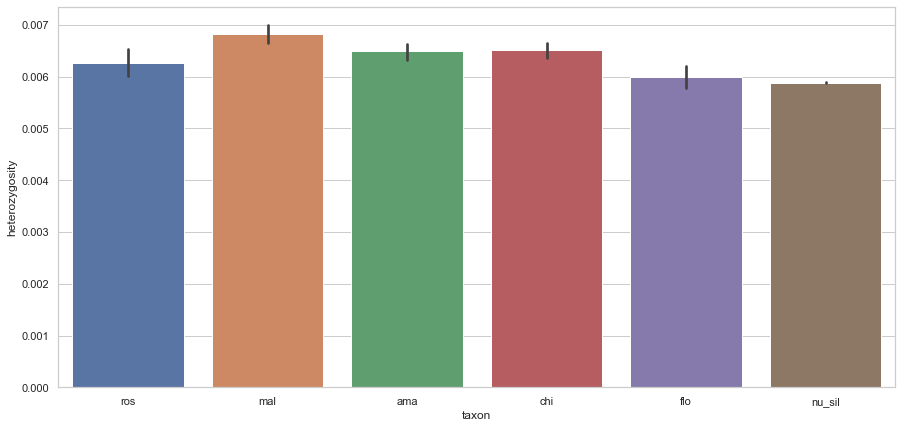

In [64]:
#SOL: Still for all sites, need to add 3rd codon pos filter.
samplespd['heterozygosity'] = hetTable
sns.barplot(x = 'taxon', y= 'heterozygosity', data = samplespd)
plt.show()

<div class="alert alert-block alert-warning">
    <b>Python: </b>
<code>groupby</code> is a very handy method when summarising information ibn dataframes. This gives the mean heterozygosity per sample:
</div>

In [34]:
samplespd.groupby('taxon').mean()

,heterozygosity
taxon,
ama,0.006488
chi,0.006510
flo,0.005988
mal,0.006820
nu_sil,0.005887
ros,0.006269


### 6.2.2 How does genetic diversity vary along chromosome 18?

Given that we are often interested in computing genetic diversity within and divergence between taxa, it is helpful to subset the GT array by taxon.

For example, if we are interested in the *Heliconius malleti* samples (named after the biologist [James Mallet](https://g.co/kgs/Y1zDhT)), we first generate a list of indices for the `mal` samples. Setting `max_allele =1` guarantees that GTs involving more than two alleles are excluded:

In [36]:
mal = samplespd[samplespd.taxon == 'mal'].index;
mal_counts = heliGTs.count_alleles(subpop = mal, max_allele=1)

<div class="alert alert-block alert-success">    
    <b>Exercise 5:</b>  Use the <code>allel</code> function <a href='https://scikit-allel.readthedocs.io/en/stable/stats/diversity.html'> <code>sequence diversity</code></a> to estimate pairwise genetic diversity (Nei's $\pi$) in <i>H. malleti</i>
    </div>

In [44]:
#SOL
pi_mal = allel.sequence_diversity(pos, mal_counts, start=1, stop=pos[-1])
print("Mean diversity within malletti is", pi_mal)

Mean diversity within malletti is 0.007624227484221339


Using the function `windowed_diversity`, we can estimate genetic diversity in windows of a specific size. Let's compute diversity in 50 kb windows:

In [37]:
pi_mal_wins, windows, n_bases, counts = allel.windowed_diversity(pos, mal_counts, size=50_000, start=1, stop=pos[-1])

<div class="alert alert-block alert-success">    
    <b>Exercise 6:</b> Add the window-wise pi estimates (stored in <code>pi_mal_wins</code>) to a new dataframe; add a column for the central position of each window.
    </div>

In [38]:
#SOL:
window_stats = pd.DataFrame(pi_mal_wins, columns = ['pi_mal']);
window_stats["coordinates"] =  windows.mean(axis=1)/1_000_000

<div class="alert alert-block alert-success">    
    <b>Exercise 7:</b> Use <code>sns.lineplot</code> to plot diversity along chromsome 18. Are there any obvious patterns?
    </div>

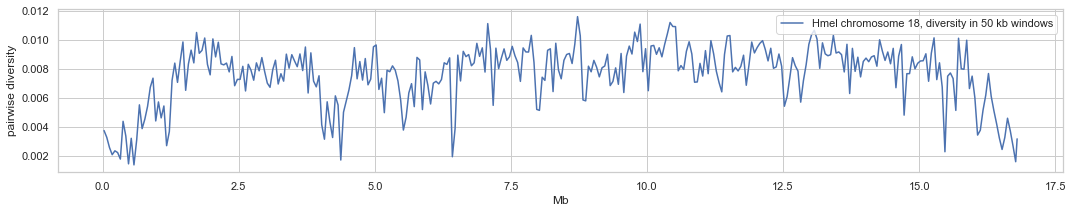

In [39]:
#SOL
fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(window_stats["coordinates"], window_stats["pi_mal"], label='Hmel chromosome 18, diversity in 50 kb windows')
plt.xlabel('Mb')
plt.ylabel('pairwise diversity')
plt.show()
# diversity is reduced at the start and end of this chromosome.
#

<div class="alert alert-block alert-success">    
    <b>Exercise 8:</b> Use <code>sns.distplot</code> to plot the distribution of window-wise diversity estimates. Does genetic diversity in 50kb windows look to be normally distributed?
    </div>

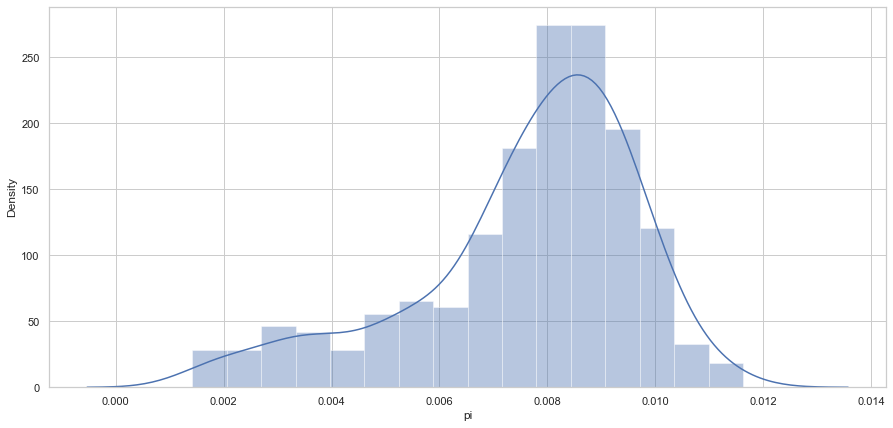

In [28]:
#SOL
sns.distplot(window_stats["pi"], label='pi in 50kb wins, n=20', norm_hist=True);
#SOL: The distribution is bimodal! The low diversity peak is due to telomeric regions... 

## 6.3. Divergence and differentiation in one focal pair of *Heliconius* butterflies

### 6.3.1  Some *Heliconius* background

If we focus on *H. malleti*, we can make four pairwise comparisons with other taxa. These are (in order of increasing distance):

        malleti vs amaryllis         A very close sympatric pair with different twing patterns
        malleti vs rosina            Equivalent to the above but allopatric
        malleti vs florencina        Sympatric species that look identical but are very diverged genetically
        malleti vs cydno             Allopatric species, even more divergent.

In this part of the practical you will be assigned to explore one of these comparisons in detail.

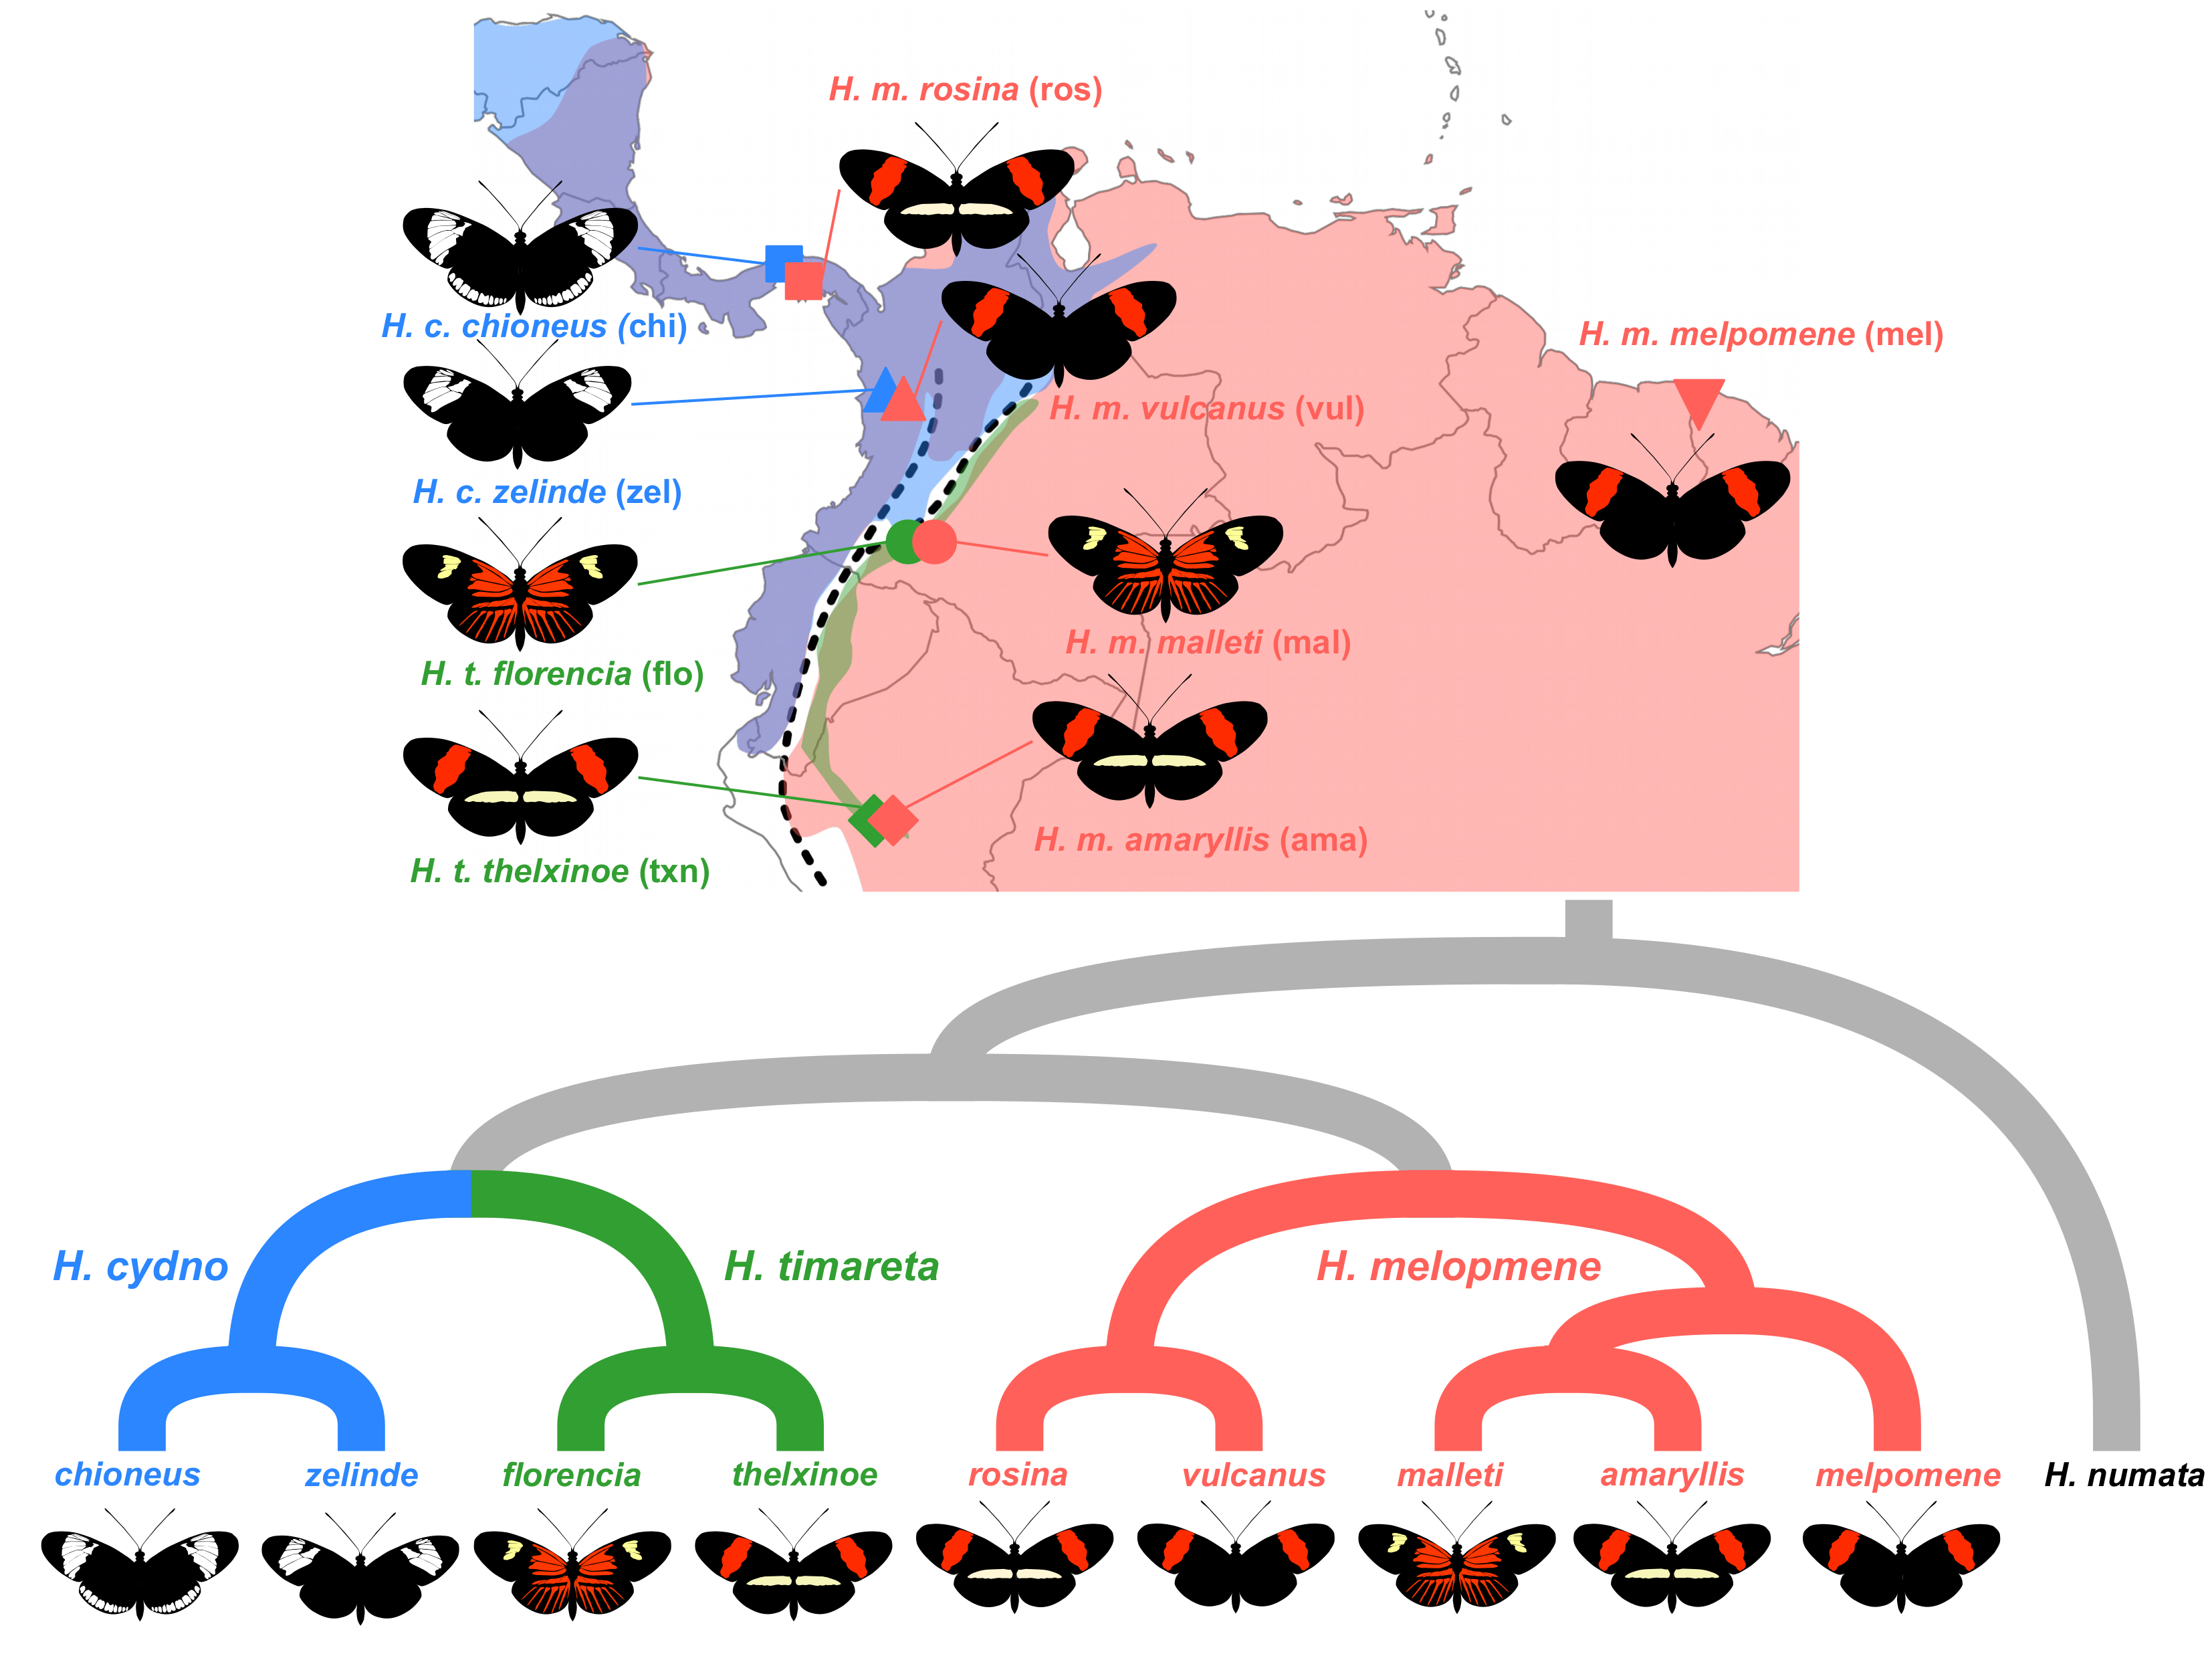

In [66]:
from IPython.display import Image
Image("/home/konrad/Dropbox/Konrad_Teaching/Population_Genomic_Analysis/map_and_tree.png")

<div class="alert alert-block alert-success">    
    <b>Exercise 9:</b> Compute $\pi$ for the other taxon in your pair. How does this compare with $\pi$ in <i>H. malleti</i> computed above?
    </div> 

In [45]:
#SOL
#### mal and ama list the indices of the mal and ama samples in the dataframe. 
ama = samplespd[samplespd.taxon == 'ama'].index
ama_counts = heliGTs.count_alleles(subpop = ama, max_allele=1)
pi_ama = allel.sequence_diversity(pos, ama_counts, start=1, stop=pos[-1])
pi_mean = (pi_mal + pi_ama)/2
print("Mean diversity within amaryllis is", pi_ama)
print("Mean diversity within malleti and amaryllis is", pi_mean)

Mean diversity within amaryllis is 0.0072385428116093446
Mean diversity within malleti and amaryllis is 0.007431385147915342


### 6.3.2 Divergence

<div class="alert alert-block alert-success">    
    <b>Exercise 10:</b> Use the function <a href = "https://scikit-allel.readthedocs.io/en/stable/stats/diversity.html">sequence_divergence</a> to compute $d_{xy}$ for your taxon pair. How does this compare to the mean genetic diversity within species?
    </div>

In [46]:
#SOL
#the scikit allel function count_alleles_subpops(subpops, max_allele=None) does this for all subpops and returns a dict. It is not clear whether this would be helpful 
#or confusing for students... It would require explaining how dicts work. I decided to keep the example notebook restricted to a single pair pairwise.
dxy_mean = allel.sequence_divergence(pos, mal_counts, ama_counts, start=1, stop=pos[-1])
#num, den = allel.hudson_fst(mal_counts, ama_counts)
#fstmean =  np.sum(num) / np.sum(den)
print("Mean d_xy between malleti and amaryllis is", dxy_mean)

Mean d_xy between malleti and amaryllis is 0.00807760502740805


<div class="alert alert-block alert-success">    
    <b>Exercise 11:</b> Compute the net divergence between the two species and use this to estimate the divergence time between the taxa assuming a model of simple species divergence (as implied by the species tree above). Assume a rate of $\mu =2.9 * 10^{-9}$ per generation  <a href = "https://academic.oup.com/mbe/article/32/1/239/2925597">(Keightley et al 2013) </a> and (see mini lecture) and 6 generations per year.
Note that this back of the envelope calculation assumes a model of strict divergence.
    </div>

In [48]:
#SOL
# Note: this calculation (and the result) would make more sense on a neutral partition rather than all sites...
mu = 2.9e-9
t_div = (dxy_mean-pi_mean)/(2 * mu)
print("Species divergence T (in generations) is", t_div)
print("Species divergence T (in years) is", t_div/6)

Species divergence T (in generations) is 111417.220602191
Species divergence T (in years) is 18569.536767031834


### 6.3.3 Measuring differentiation using $F_{st}$

<div class="alert alert-block alert-success">    
    <b>Exercise 12:</b> Use your estimate of $d_{xy}$ and mean $\pi$ between your two taxa to calculate $F_{st}$.
    </div>

In [50]:
#SOL
fst_mal_ama = (dxy_mean - pi_mean)/(dxy_mean + pi_mean)
print("F_st = (d_xy - pi_mean)/(d_xy + pi_mean) between malleti and amaryllis is", fst_mal_ama)

F_st = (d_xy - pi_mean)/(d_xy + pi_mean) between malleti and amaryllis is 0.04166743754347842


<div class="alert alert-block alert-success">    
    <b>Exercise 13:</b> Let's assume that the data were generated under a completely different model of population history, an equilibrium model of symmetric migration. In this case, we can use Wright's result for the expected $F_{st}$ to estimate the scaled migration rate, i.e. the number of migrants $M =  4N_e m$.

<b>Hint</b>: For the case of geneflow between two populations/taxa, Wright's result is: $E[F_{ST}]=\frac{1}{1+8M}$
    </div>

In [51]:
#SOL
print("Assuming equilibrium migration, Fst implies", ((1/fst_mal_ama )-1)/8, "migrants per generation")

Assuming equilibrium migration, Fst implies 2.8749444978964007 migrants per generation


<div class="alert alert-block alert-success">    
    <b>Exercise 14:</b> Estimate diversity for the other taxon in your pair in 50kb windows and add these estimates to the dataframe <code>window_stats</code> you have defined previously. Plot window-wise diversity of BOTH taxa along the chromosome
    </div>

In [52]:
#SOL
pi_ama_wins, windows, n_bases, counts = allel.windowed_diversity(pos, ama_counts, size=50_000, start=1, stop=pos[-1])
window_stats["pi_ama"] = pi_ama_wins

In [53]:
window_stats

,pi_mal,coordinates,pi_ama
0,0.003782,0.025000,0.002489
1,0.003319,0.075000,0.002358
2,0.002615,0.125000,0.001740
3,0.002120,0.175001,0.001278
4,0.002387,0.225000,0.001875
...,...,...,...
332,0.004630,16.625000,0.005253
333,0.003778,16.675000,0.004287
334,0.002742,16.725001,0.003142
335,0.001636,16.775001,0.001979


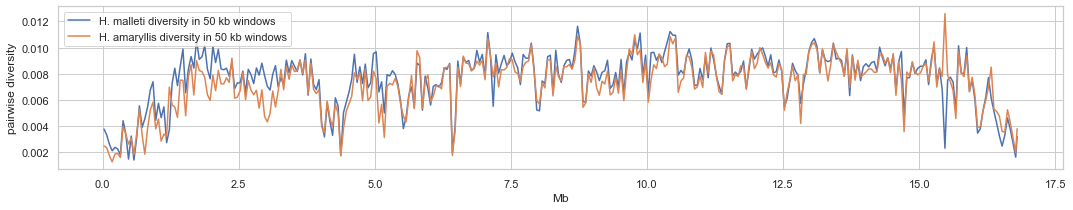

In [54]:
#SOL
fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(window_stats["coordinates"], window_stats["pi_mal"], label='H. malleti diversity in 50 kb windows')
sns.lineplot(window_stats["coordinates"], window_stats["pi_ama"], label='H. amaryllis diversity in 50 kb windows')
plt.xlabel('Mb')
plt.ylabel('pairwise diversity')
plt.show()
# divversity is reduced at the start and end of this chromosome.

<div class="alert alert-block alert-success">    
    <b>Exercise 15:</b> The functions <code>windowed_divergence</code> and <code>windowed_patterson_fst</code> have analogous syntax to <code>windowed_diversity</code>. Estimate $d_{XY}$ and $F_{st}$ between <i>H. malleti</i> and your focal taxon in 50kb windows and add these estimates to the <code>window_stats</code> dataframe.
    </div>

In [56]:
#SOL
dxy_mal_ama_wins, windows, n_bases, counts = allel.windowed_divergence(pos, mal_counts, ama_counts, size=50_000, start=1, stop=pos[-1])
fst_mal_ama_wins, windows, counts = allel.windowed_patterson_fst(pos, mal_counts, ama_counts, size=50_000, start=1, stop=pos[-1])
window_stats["dxy"] =  dxy_mal_ama_wins
window_stats["fst"] = fst_mal_ama_wins

<div class="alert alert-block alert-success">    
    <b>Exercise 16:</b> Plot $F_{ST}$ along the chromosome and include a line defining the 5% of windows with highest $F_{st}$
    </div>

In [57]:
quantile95_fst = window_stats["fst"].quantile(.95);
print(quantile95_fst)

0.2569731405600356


Text(0, 0.5, 'Fst')

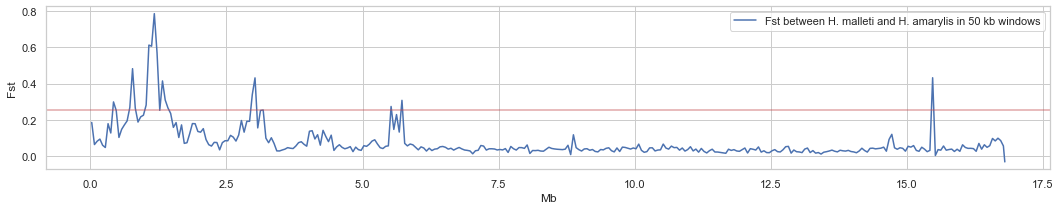

In [58]:
#SOL
fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(window_stats["coordinates"], window_stats["fst"], label='Fst between H. malleti and H. amarylis in 50 kb windows')
plt.axhline(y=quantile95_fst, alpha=0.5, color ='r')
plt.xlabel('Mb')
plt.ylabel('Fst')

In [67]:
optix_pos = np.array([1058778, 1159581])

The gene *optix* is situated at the beginning ($\approx 1Mb$) of chromosome 18 encodes red wing patterns on the fore and hind wings (see [Jiggins et al 2017](https://royalsocietypublishing.org/doi/full/10.1098/rstb.2015.0485))
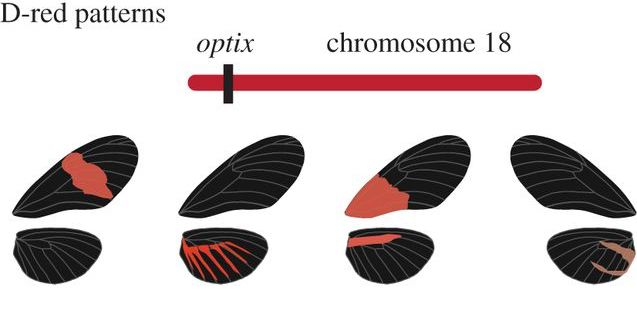

<div class="alert alert-block alert-success">    
    <b>Exercise 16:</b> Given the wing patterns of your two taxa, would you expect <i>optix</i> to be fixed for different alleles? Indicate the location of <i>optix</i> on the $F_{st}$ plot. Is <i>optix</i> an $F_{st}$ outlier?
    
<b>Hint</b>: You can define a vertical line at some position using <code>plt.axvline(x= pos, linewidth=20, alpha=0.6)</code>
    </div>

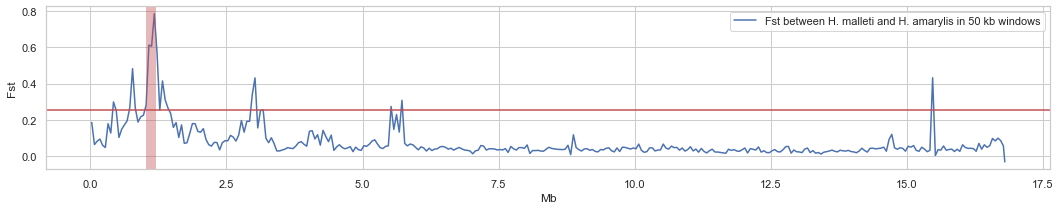

In [70]:
#SOL
#Define the position of optix:
optix_pos.mean()/1e6
#H. malleti and H. amaryllis differ in red wing patterns. Given that these are under the control of optix it is 
# not surprising that this co-incides with the bigget F_st peak!   
fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(window_stats["coordinates"], window_stats["fst"], label='Fst between H. malleti and H. amarylis in 50 kb windows')
plt.axhline(y = quantile95_fst, alpha=1, color ='r')
plt.axvline(x = optix_coords.mean()*1e-6, linewidth=10, alpha=0.4, color ='r')
plt.xlabel('Mb')
plt.ylabel('Fst')
plt.show()

<div class="alert alert-block alert-success">    
    <b>Exercise 17:</b> Are outliers in $F_{st}$ on chromsome 18 driven by reduced genetic diversity or increased divergence? Plot mean $\pi$ against $d_{xy}$ and highlight the 5% outliers.

 <b>Hint</b>: It may be easiest to add a column indicating $F_{st}$ outliers to the dataframe (see practical 4 for an example of how to do this using <code>np.where()</code>. For plotting <a href = "https://seaborn.pydata.org/generated/seaborn.scatterplot.html"> <code>sns.scatterplot</code></a> does the trick!
    </div>

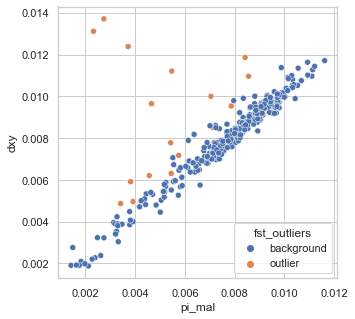

In [71]:
#SOL
# This adds a column with Fst outliers to the dataframe.
window_stats['fst_outliers'] = np.where(window_stats['fst'] > quantile95_fst , 'outlier', 'background')
#SOL
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=window_stats, x="pi_mal", y="dxy", hue = 'fst_outliers');

<div class="alert alert-block alert-success">    
    <b>Exercise 18:</b> Plot the distribution of window-wise $F_{st}$
    </div>

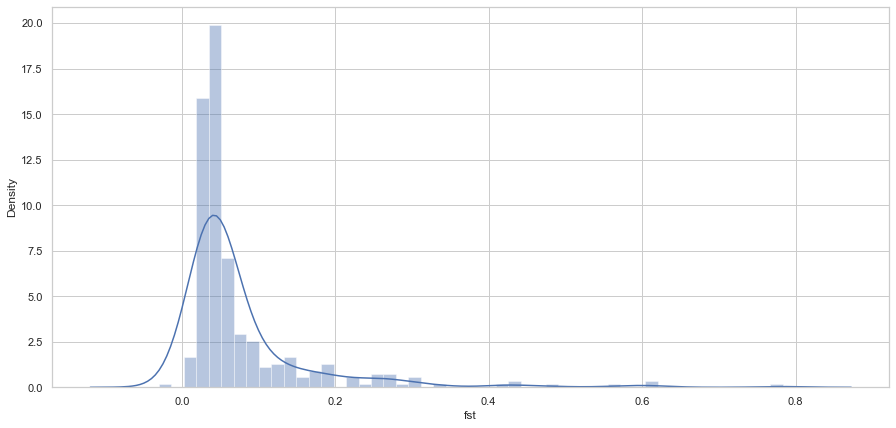

In [73]:
#SOL
sns.distplot(window_stats["fst"], label='fst in 50kb wins, n=20', norm_hist=True)
plt.show()

<div class="alert alert-block alert-success">    
    <b>Exercise 19:</b> Given your estimates of $T$ under a history of divergence and an estimate of $N_e$, simulate a dataset of the same size as the chromsome 18 dataset, consisting of 50kb windows. How well does the observed distribution of $F_{st}$ fit the simulated distribution?
    </div>

We will ignore linkage between windows, i.e. we assume that windows are simulation replicates:

In [84]:
#SOL This is the stuff the student should work out
num_windows = len(window_stats)
Ne =   pi_mean/(4 * mu) 
print("Species divergence T (in generations) is", t_div, "generations")
print("Mean Ne for malleti and amaryllis and their ancestor is", Ne )
print("There are", num_windows, "windows")

Species divergence T (in generations) is 111417.220602191 generations
Mean Ne for malleti and amaryllis and their ancestor is 640636.650682357
There are 337 windows


The code chunk below sets up a simulation for a history of divergence between two species. For more info on the syntax see the `msprime` [manual](https://tskit.dev/msprime/docs/stable/demography.html). 

The values are arbitrary and need to be adjusted according to your dataset... 

In [108]:
# This will be first multi population simulation in the course! It makes sense to provide the code chunk below 
# perhaps without some of the values...
sample_size = 10

#Rates for migration, recombination and mutation are unscaled and per generation:
sequence_length = 50e3
recr = 1.84675e-8

demography = msprime.Demography()
demography.add_population(name="Hmal", initial_size=Ne)
demography.add_population(name="Hama", initial_size= Ne)
demography.add_population(name="ancestor", initial_size= Ne)
demography.add_population_split(time = t_div, derived=["Hmal", "Hama"], ancestral="ancestor")
replicates = msprime.sim_ancestry(samples={"Hmal": sample_size, "Hama" : sample_size}, 
                          sequence_length = sequence_length, recombination_rate=recr, random_seed = 123,
                          demography=demography, num_replicates = num_windows)

In [109]:
#SOL
mu = 2.9e-9
sim_Fst = np.zeros(num_windows)
sim_div = np.zeros(num_windows)
sim_piA = np.zeros(num_windows)
sim_piB = np.zeros(num_windows)
for replicate_index, ts in enumerate(replicates):
    A = ts.samples()[0:20]
    B = ts.samples()[20:40]
    ts_muts = msprime.sim_mutations(ts, rate=mu, random_seed=5678)
    sim_Fst[replicate_index] = ts_muts.Fst(sample_sets=[A, B])
    sim_div[replicate_index] = ts_muts.divergence(sample_sets=[A, B])
    sim_piA[replicate_index] = ts_muts.diversity(A)
    sim_piB[replicate_index] = ts_muts.diversity(B)

Once you have an array of simulated $F_{st}$ values `sim_Fst`, you can use the code below to plot both simulated and real distribution: 

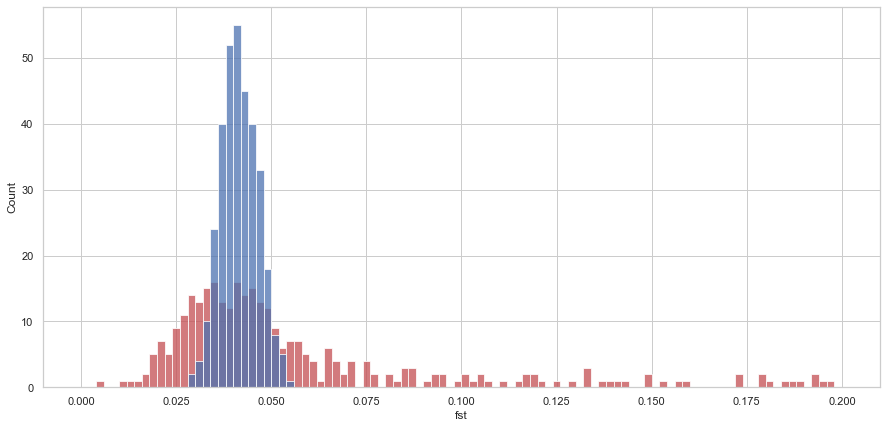

In [110]:
sns.histplot(window_stats["fst"], color= 'r', binwidth = 0.002, binrange = [0,0.2])
sns.histplot(sim_Fst, color= 'b', binwidth = 0.002, binrange = [0,0.2])
plt.show()

<div class="alert alert-block alert-success">    
    <b>Exercise 20:</b> How well does the real data fit the simulated data? How would you improve the fit?
    </div>

## 6.4 Class discussion

<div class="alert alert-block alert-success">    
Add the chromosome wide summary statistics (and popgen estimates of divergence based on those) for your focal pair to the class google doc. Don't forget to fill in the questions about $F_{st}$ around <i>optix</i>
    </div>

In [132]:
#SOL: ADD link. Columns for the class spreadsheet should include:
#mean dxy, pi and Fst for chrom 18, the rank of the optix window's F_st
#

To find the rank of the $F_{st}$ value of the window around *optix*, let's first add a new column with the ranks of all windows to the data frame `window_stats`. 

Note: `.rank()` ranks values from lowest to highest. `num_windows - fst_rank`reverses the order: 

In [111]:
fst_rank = window_stats["fst"].rank(method='max');
window_stats['fst_rank'] = num_windows - fst_rank

Next we need to find the window containing optix. Given that we've set the window length to 50_000, the index of this window is pos/50_000:

In [112]:
print("The number of windows is", num_windows)
optix_index = round(optix_coords.mean()/50_000)
print("The window containing optix has coordinates", optix_index)

The number of windows is 337
The window containing optix has coordinates 22


In [115]:
print("Window mean position is:", window_stats['coordinates'][optix_index])
print("The centre of optix is at", optix_coords.mean()/1e6)

Window mean position is: 1.1250005
The centre of optix is at 1.1091795


The three windows around optix have the higher $F_{st}$ on chromosome 18:

In [207]:
print("Fst ranks are:")
window_stats['fst_rank'][21:24]

Fst ranks are:


21    1.0
22    2.0
23    0.0
Name: fst_rank, dtype: float64

<div class="alert alert-block alert-success">    
    <b>Class discussion questions:</b>
    <ul>
 <li> How does the mean Fst estimated for chromosome 18 differ between taxon pairs?</li>
 <li> How does the mean $d_{xy}$</li>
 <li> Do the pairs differ by how much $F_{st}$ and $d_{xy}$ vary?</li>  
 <li> If we rank all windows (in terms of $F_{st}$), where does <i>optix</i> fall?</li>
        </ul>
    </div>

## Thoughts & To Do

- One could split up the class into two sets of analyses: all sites vs intergenic and compare results!
- Include link for data upload and google docs
- Include the Mig model? Or split the class one half div, one half mig?